In [1]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

import tensorflow as tf
from enum import Enum
import cv2
from tensorflow.keras import backend as K
import gc
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from keras_adabound import AdaBound
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, SpatialDropout2D,
    AvgPool2D, MaxPool2D, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D,
    Flatten, Dense
)
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow_addons.metrics import CohenKappa
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.applications import (
    ResNet152V2, ResNet50, DenseNet169,DenseNet121
)
from numpy import dstack
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from keras.callbacks import ModelCheckpoint
import datetime
from skimage.transform import rescale, resize
import keras
import pickle
from skimage.io import imread
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from keras.models import load_model
import keras.utils
import tensorflow_addons as tfa
from tensorflow_addons.metrics import CohenKappa
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as s

/usr/local/anaconda3/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Set seed in order to maintain the Train/ Test/ Valid contents in any environment.

In [2]:
# define seed number to have reproducible experiments.
seed = 3352024
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
def load_path(path):
    
    '''
    load MURA dataset
    '''
    dataset = [] 
    for body in os.listdir(path):
        body_part = body
        path_p = path+'/'+str(body)
        for id_p in os.listdir(path_p):
            patient_id = id_p
            path_id = path_p+'/'+str(id_p)
            for lab in os.listdir(path_id):
                if lab.split('_')[-1]=='positive': 
                    label = 1 
                elif lab.split('_')[-1]=='negative':
                    label= 0
                path_l = path_id+'/'+str(lab)
                for img in os.listdir(path_l):  
                    img_path = path_l + '/' + str(img)
                    dataset.append(
                        {
                            'body_part': body_part,
                            'patient_id': patient_id,
                            'label': label,
                            'img_path': img_path
                        }
                    )
    return dataset

### Set the path where you stored your dataset

In [4]:
path = '/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/MURA-v1.1/train'
os.listdir(path)

['XR_ELBOW']

In [5]:
dataset = load_path(path)
df_train = pd.DataFrame(dataset)
df_train.head()

,body_part,patient_id,label,img_path
0,XR_ELBOW,patient02946,0,/Users/rac/Desktop/Project/MURA_Modified/Mura_...
1,XR_ELBOW,patient02946,0,/Users/rac/Desktop/Project/MURA_Modified/Mura_...
2,XR_ELBOW,patient05951,0,/Users/rac/Desktop/Project/MURA_Modified/Mura_...
3,XR_ELBOW,patient05951,0,/Users/rac/Desktop/Project/MURA_Modified/Mura_...
4,XR_ELBOW,patient05509,0,/Users/rac/Desktop/Project/MURA_Modified/Mura_...


In [6]:
dataset_test = load_path(path = '/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/MURA-v1.1/valid')
df_test = pd.DataFrame(dataset_test)
df_test.head()

,body_part,patient_id,label,img_path
0,XR_ELBOW,patient11793,1,/Users/rac/Desktop/Project/MURA_Modified/Mura_...
1,XR_ELBOW,patient11793,1,/Users/rac/Desktop/Project/MURA_Modified/Mura_...
2,XR_ELBOW,patient11793,1,/Users/rac/Desktop/Project/MURA_Modified/Mura_...
3,XR_ELBOW,patient11793,1,/Users/rac/Desktop/Project/MURA_Modified/Mura_...
4,XR_ELBOW,patient11793,1,/Users/rac/Desktop/Project/MURA_Modified/Mura_...


## Train
### Set the path where you stored your train csv accordingly.

In [7]:
#csv files path
path = '/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/MURA-v1.1'
train_image_paths_csv = "MURA_ELBOW_Train_ImagePath.csv"

In [8]:
train_images_paths = pd.read_csv(os.path.join(path,train_image_paths_csv),dtype=str,header=None)
train_images_paths.columns = ['image_path']

In [9]:
train_images_paths['label'] = train_images_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
train_images_paths['category']  = train_images_paths['image_path'].apply(lambda x: x.split('/')[3])  
train_images_paths['patientId']  = train_images_paths['image_path'].apply(lambda x: x.split('/')[4].replace('patient',''))
train_images_paths.head()

,image_path,label,category,patientId
0,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project
1,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project
2,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project
3,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project
4,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project


## Valid
### Set the path where you stored your valid csv accordingly.

In [10]:
path = '/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/MURA-v1.1'
valid_image_paths_csv = "MURA_ELBOW_Valid_ImagePath.csv"
valid_data_paths = pd.read_csv(os.path.join(path,valid_image_paths_csv),dtype=str,header=None)
valid_data_paths.columns = ['image_path']

In [11]:
valid_data_paths['label'] = valid_data_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
valid_data_paths['category']  = valid_data_paths['image_path'].apply(lambda x: x.split('/')[3])  
valid_data_paths['dir'] =  valid_data_paths['image_path'].apply(lambda x: x.split('/')[1])
valid_data_paths['patientId']  = valid_data_paths['image_path'].apply(lambda x: x.split('/')[4].replace('patient',''))
valid_data_paths.head()

,image_path,label,category,dir,patientId
0,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project
1,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project
2,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project
3,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project
4,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project


In [12]:
train_images_paths['label_index']= train_images_paths.label
train_images_paths.label_index.replace('positive', 1, inplace=True)
train_images_paths.label_index.replace('negative', 0, inplace=True)
train_images_paths.head()

,image_path,label,category,patientId,label_index
0,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project,1
1,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project,1
2,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project,1
3,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project,1
4,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Project,1


In [13]:
valid_data_paths['label_index']= valid_data_paths.label
valid_data_paths.label_index.replace('positive', 1, inplace=True)
valid_data_paths.label_index.replace('negative', 0, inplace=True)
valid_data_paths.head()

,image_path,label,category,dir,patientId,label_index
0,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project,1
1,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project,1
2,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project,1
3,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project,1
4,/Users/rac/Desktop/Project/MURA_Modified/Mura_...,positive,Desktop,Users,Project,1


### Data Preprocessing

In [14]:
im_size = 224

In [15]:
def random_rotation_flip(image,size = 224):
    if random.randint(0,1):
        image = cv2.flip(image,1) # 1-->horizontal flip 0-->Vertical flip -1-->Horizontal and vertical

    if random.randint(0,1):
            angle = random.randint(-30,30)
            M = cv2.getRotationMatrix2D((size/2,size/2),angle,1)
            #The third parameter: the size of the transformed image
            image = cv2.warpAffine(image,M,(size,size))
    return image

In [16]:
def image_loader(Path, size = 224): 
    Images = []
    for path in tqdm(Path):
        try:
            image = cv2.imread(path)
            image = random_rotation_flip(image,size)
            Images.append(image)
        except Exception as e:
            print(str(e))   
    return Images

In [17]:
#X_train = image_loader(train_images_paths['image_path'][:50,],im_size)
X_train = image_loader(train_images_paths['image_path'],im_size)

100%|██████████| 4931/4931 [00:14<00:00, 351.43it/s]


In [18]:
y_train = train_images_paths['label']
y_train

0       positive
1       positive
2       positive
3       positive
4       positive
          ...   
4926    negative
4927    negative
4928    negative
4929    negative
4930    negative
Name: label, Length: 4931, dtype: object

In [19]:
Y_train = y_train.replace("positive",1)
Y_train = Y_train.replace("negative",0)

In [20]:
X_test = image_loader(valid_data_paths['image_path'],im_size)

100%|██████████| 465/465 [00:01<00:00, 359.18it/s]


In [21]:
y_test = valid_data_paths['label']

In [22]:
Y_test = y_test.replace("positive",1)
Y_test = Y_test.replace("negative",0)

## Applying Train and Test Spliting Function

In [23]:
train, valid = train_test_split(train_images_paths, test_size=0.2,random_state=seed)

In [24]:
test = valid_data_paths.drop(['dir'], axis=1)

In [25]:
im_size = 224

### Generating Train/Valid/Test generators

In [26]:
image_generator = ImageDataGenerator()

In [27]:
train_generator = image_generator.flow_from_dataframe(dataframe = train,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=False,seed=seed)
valid_generator = image_generator.flow_from_dataframe(dataframe = valid,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw',target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=False,seed=seed)
test_generator = image_generator.flow_from_dataframe(dataframe = test,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = False,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest', validate_filenames=False,seed=seed)

Found 3944 non-validated image filenames.
Found 987 non-validated image filenames.
Found 465 non-validated image filenames.


In [28]:
CLASSES = 2
input_shape = (im_size,im_size,3)

## Applying Metric-AUC,BinaryAccuracy and CohenKappa

In [29]:
def metrics():
    return [
        AUC(name="auc"),
        BinaryAccuracy("accuracy"),
        CohenKappa(name="kappa", num_classes=2)
    ]

## Generating AUC, Loss and Kappa Loss plots for evaluation.

In [30]:
def plot_history(hs, epochs, metric):
    if metric=='loss': 
                label_y = 'Loss'
    elif metric=='accuracy': 
               label_y = 'Accuracy'
    elif metric=='auc': 
               label_y = 'AUC'
    else : label_y = 'kappa'
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel(label_y)
    plt.legend()
    plt.show()

def print_results(model_name,epochs,hs,model_eval):
    print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
    print("Test Loss      : {0:.5f}".format(model_eval[0]))
    print("---")
    print("Train AUC     : {0:.5f}".format(hs.history['auc'][-1]))
    print("Validation AUC: {0:.5f}".format(hs.history['val_auc'][-1]))
    print("Test AUC      : {0:.5f}".format(model_eval[1]))
    print("---")
    print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][-1]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][-1]))
    print("Test Accuracy      : {0:.5f}".format(model_eval[2]))
    print("---")
    print("Train Kappa     : {0:.5f}".format(hs.history['kappa'][-1]))
    print("Validation Kappa: {0:.5f}".format(hs.history['kappa'][-1]))
    print("Test Kappa      : {0:.5f}".format(model_eval[3]))
    # Plot train and validation error per epoch.
    plot_history(hs={model_name: hs}, epochs=epochs, metric='loss')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='auc')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='accuracy')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='kappa')

### Model Cleanup

In [31]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect() #garbage collection
    print("...Finished clean up...")

## Setting ReducedLROnPlateau and Earlystopping configurations as CallBacks.

In [32]:
my_callbacks = [
                keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',     # Reduce learning rate when a metric has stopped improving.
                                                      factor=0.1,
                                                      patience=3,
                                                      min_delta=0.001,
                                                      verbose=1,
                                                      min_lr=0.000000001),
                keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3, #5
                                                  mode="max",
                                                  baseline=None,
                                                  restore_best_weights=True)
                ]

# Applying Deep Learning Models

### RESNET50 Pre-trained Model

In [33]:
def ResNet50PreBuilder(pooling="max", shape=(224, 224, 3), trainable_layers_after=None):
    base_model_res = ResNet50(input_shape= shape, include_top=False, weights="imagenet", pooling= pooling)
    for layer in base_model_res.layers:
        layer.trainable = False
    prediction_layer = Dense(1, activation="sigmoid",name="RESNET50_output_sigmoid")
    model = Sequential(layers=[base_model_res,prediction_layer],name="RESNET50")
    return model 

94765736/94765736 [==============================] - 35s 0us/step
Epoch 1/15
62/62 [==============================] - 556s 9s/step - loss: 0.6265 - auc: 0.6748 - accuracy: 0.6531 - kappa: 0.2498 - val_loss: 0.6012 - val_auc: 0.7221 - val_accuracy: 0.6960 - val_kappa: 0.3575 - lr: 0.0010
Epoch 2/15
62/62 [==============================] - 630s 10s/step - loss: 0.5533 - auc: 0.7669 - accuracy: 0.7234 - kappa: 0.4069 - val_loss: 0.5631 - val_auc: 0.7531 - val_accuracy: 0.7386 - val_kappa: 0.4092 - lr: 0.0010
Epoch 3/15
62/62 [==============================] - 692s 11s/step - loss: 0.5252 - auc: 0.7956 - accuracy: 0.7444 - kappa: 0.4505 - val_loss: 0.5797 - val_auc: 0.7582 - val_accuracy: 0.7123 - val_kappa: 0.3976 - lr: 0.0010
Epoch 4/15
62/62 [==============================] - 744s 12s/step - loss: 0.5063 - auc: 0.8142 - accuracy: 0.7599 - kappa: 0.4857 - val_loss: 0.5516 - val_auc: 0.7663 - val_accuracy: 0.7467 - val_kappa: 0.4362 - lr: 0.0010
Epoch 5/15
62/62 [=========================

/usr/local/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved /Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_RESNET50Final_CLAHE.h5
8/8 [==============================] - 55s 7s/step - loss: 0.5292 - auc: 0.8159 - accuracy: 0.7419 - kappa: 0.4821
...Finished clean up...
Train Loss     : 0.44982
Validation Loss: 0.54880
Test Loss      : 0.52918
---
Train AUC     : 0.86320
Validation AUC: 0.78697
Test AUC      : 0.81590
---
Train Accuracy     : 0.79868
Validation Accuracy: 0.73759
Test Accuracy      : 0.74194
---
Train Kappa     : 0.56840
Validation Kappa: 0.56840
Test Kappa      : 0.48209


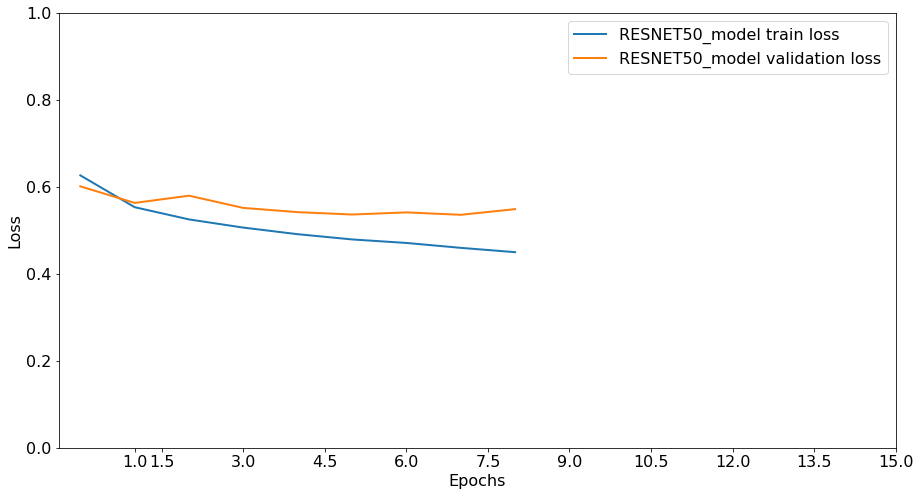

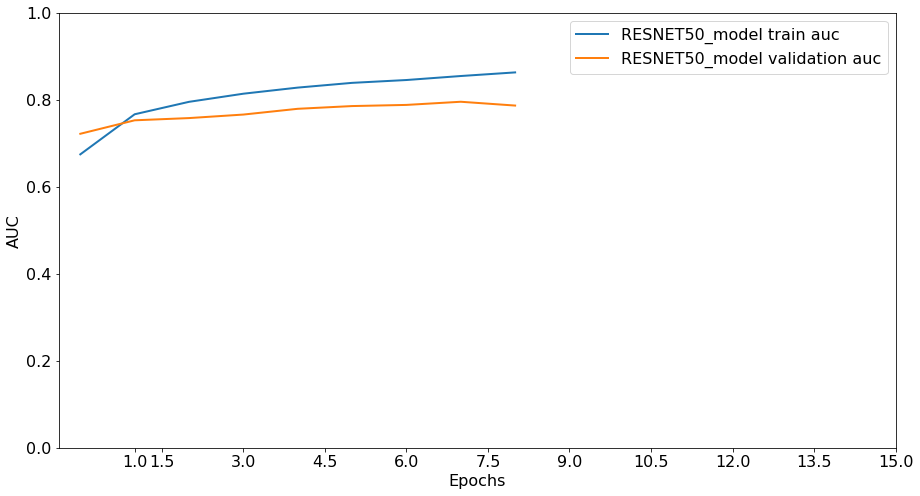

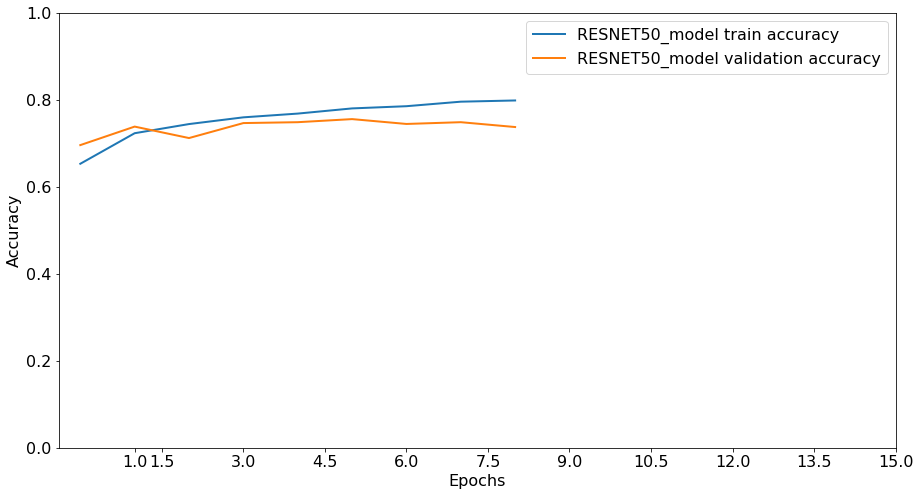

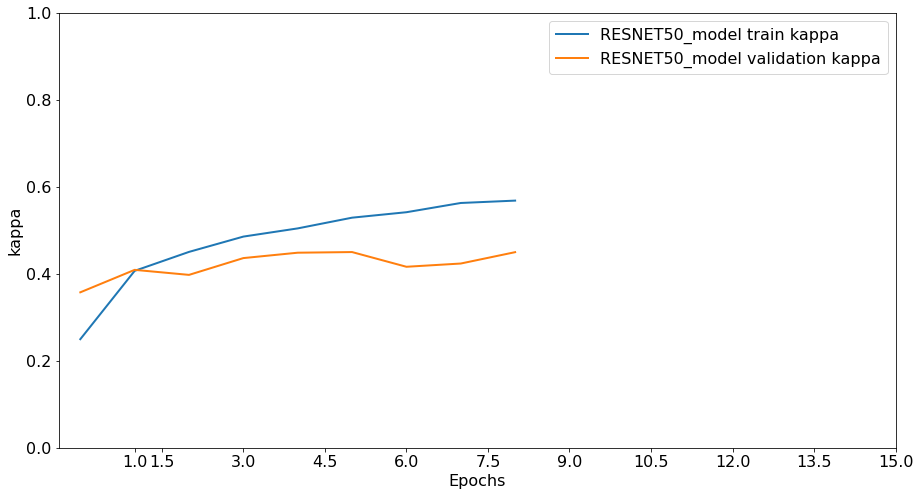

In [34]:
epochs = 15
RESNET50_model = ResNet50PreBuilder(pooling='avg')
RESNET50_model.compile(optimizer=Adam(learning_rate= 0.001), loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = RESNET50_model.fit(train_generator,validation_data = valid_generator, epochs = epochs,callbacks= my_callbacks)
print('Finished training.')
print('------------------')
RESNET50_model.summary()
filename = '/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_RESNET50Final_CLAHE.h5'
RESNET50_model.save(filename)
print('>Saved %s' % filename)
RESNET50_model_eval = RESNET50_model.evaluate(test_generator)
clean_up(model=RESNET50_model)
print_results(model_name='RESNET50_model',epochs= epochs,hs = hs,model_eval = RESNET50_model_eval)

## Applying Confusion Matrix

### Train Data

62/62 [==============================] - 515s 8s/step


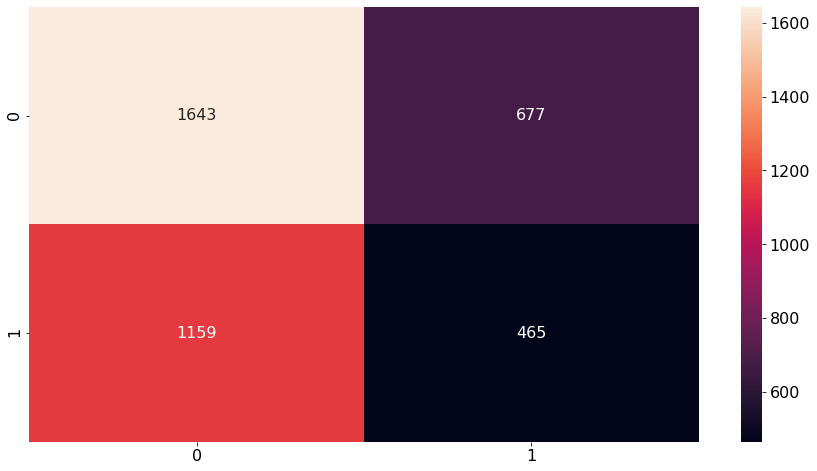

In [36]:
import seaborn as sn
y_pred_train= RESNET50_model.predict(train_generator) # validate Predictions
y_train = train.label_index.values
y_pred_train_binary = [1 if val >= 0.5 else 0 for val in y_pred_train.ravel()]
cm = confusion_matrix(y_train,y_pred_train_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [37]:
tn, fp, fn, tp = confusion_matrix(y_train,y_pred_train_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 465
True Negatives: 1643
False Positives: 677
False Negatives: 1159


### Valid Data

16/16 [==============================] - 110s 7s/step


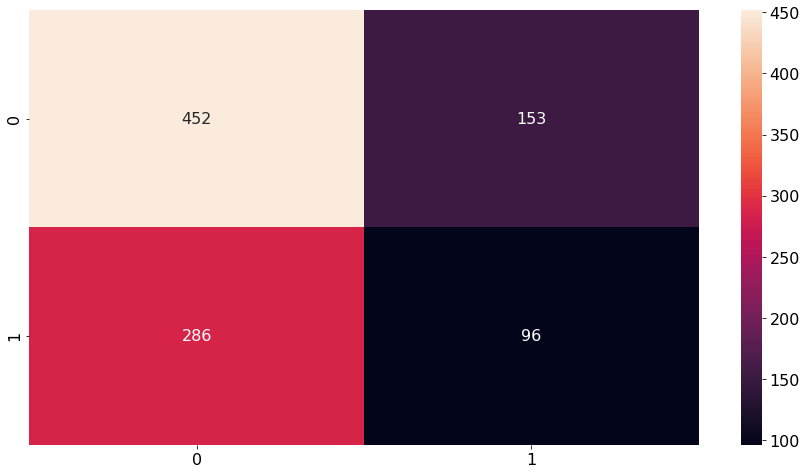

In [38]:
from sklearn.metrics import confusion_matrix
from keras.models import load_model
# Tensorflow addons for matrix
import keras.utils
#from keras.utils import tf_utils
import tensorflow_addons as tfa
from tensorflow_addons.metrics import CohenKappa
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sn

y_pred_valid= RESNET50_model.predict(valid_generator)
y_valid = valid.label_index.values
y_pred_binary = [1 if val >= 0.5 else 0 for val in y_pred_valid.ravel()]
cm = confusion_matrix(y_valid,y_pred_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [39]:
tn, fp, fn, tp = confusion_matrix(y_valid,y_pred_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 96
True Negatives: 452
False Positives: 153
False Negatives: 286


### Test Data

8/8 [==============================] - 48s 6s/step


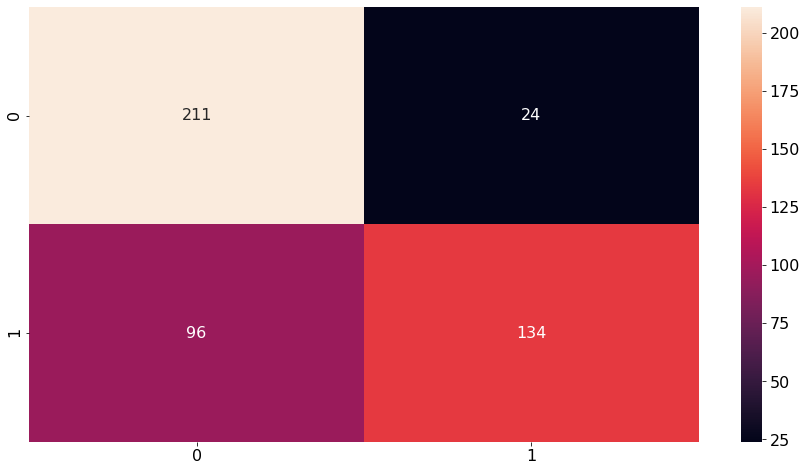

In [40]:
y_pred_test=  RESNET50_model.predict(test_generator) 
y_test = test.label_index.values
y_pred_test_binary = [1 if val >= 0.5 else 0 for val in y_pred_test.ravel()]
cm = confusion_matrix(y_test,y_pred_test_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [41]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_test_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 134
True Negatives: 211
False Positives: 24
False Negatives: 96


### VGG16 Pre-trained Model

In [43]:
import tensorflow as tf 
from tensorflow.keras.applications.vgg16 import VGG16
from keras import layers
from tensorflow.keras.layers import Input, Conv2D,BatchNormalization
from tensorflow.keras.layers import Activation,SpatialDropout2D,AvgPool2D
from tensorflow.keras.layers import MaxPool2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D,Flatten,Dropout,Dense

base_model_vgg = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

for layer in base_model_vgg.layers:
    layer.trainable = False
    
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model_vgg.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

VGG16_model = tf.keras.models.Model(base_model_vgg.input, x)    

Epoch 1/15
62/62 [==============================] - 1794s 29s/step - loss: 4.5954 - auc: 0.5733 - accuracy: 0.5877 - kappa: 0.1329 - val_loss: 0.6119 - val_auc: 0.7247 - val_accuracy: 0.7031 - val_kappa: 0.3280 - lr: 0.0010
Epoch 2/15
62/62 [==============================] - 1431s 23s/step - loss: 0.5809 - auc: 0.7381 - accuracy: 0.6993 - kappa: 0.3530 - val_loss: 0.5499 - val_auc: 0.7895 - val_accuracy: 0.7376 - val_kappa: 0.4227 - lr: 0.0010
Epoch 3/15
62/62 [==============================] - 1405s 23s/step - loss: 0.5246 - auc: 0.8012 - accuracy: 0.7335 - kappa: 0.4240 - val_loss: 0.5235 - val_auc: 0.8063 - val_accuracy: 0.7629 - val_kappa: 0.4636 - lr: 0.0010
Epoch 4/15
62/62 [==============================] - 1153s 19s/step - loss: 0.4689 - auc: 0.8435 - accuracy: 0.7497 - kappa: 0.4553 - val_loss: 0.5055 - val_auc: 0.8186 - val_accuracy: 0.7639 - val_kappa: 0.4833 - lr: 0.0010
Epoch 5/15
62/62 [==============================] - 1098s 18s/step - loss: 0.4052 - auc: 0.8801 - accura

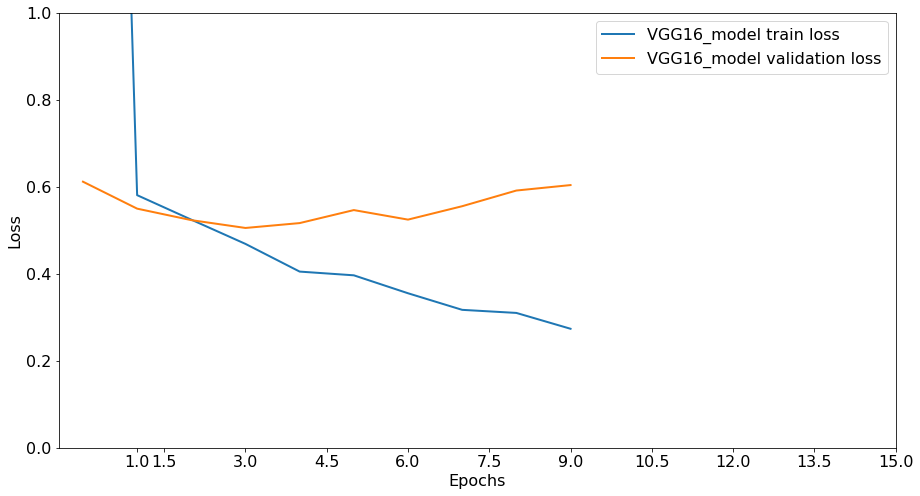

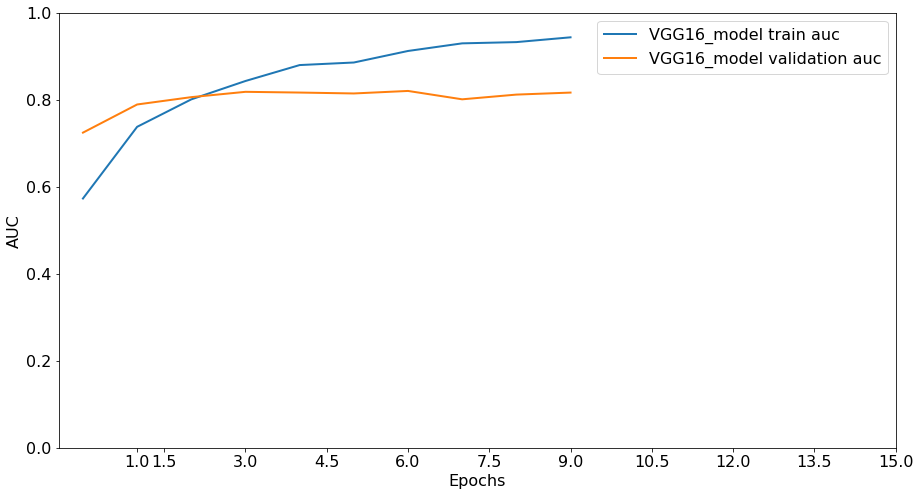

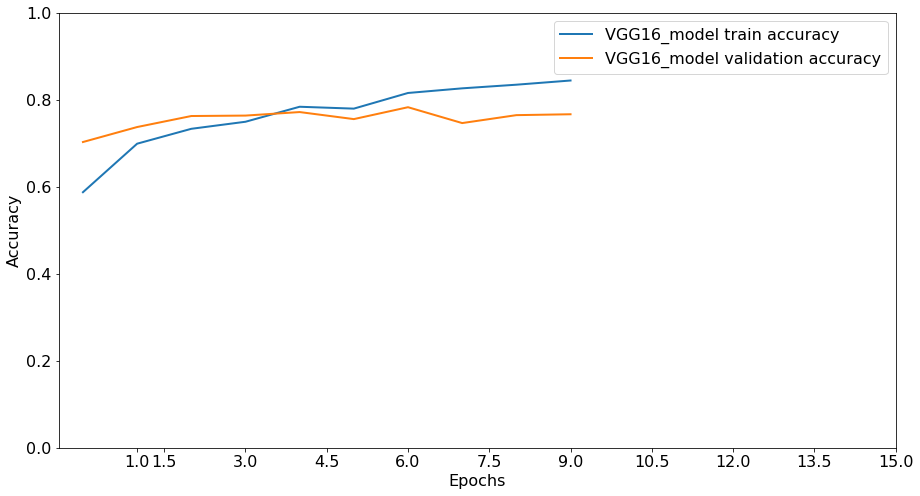

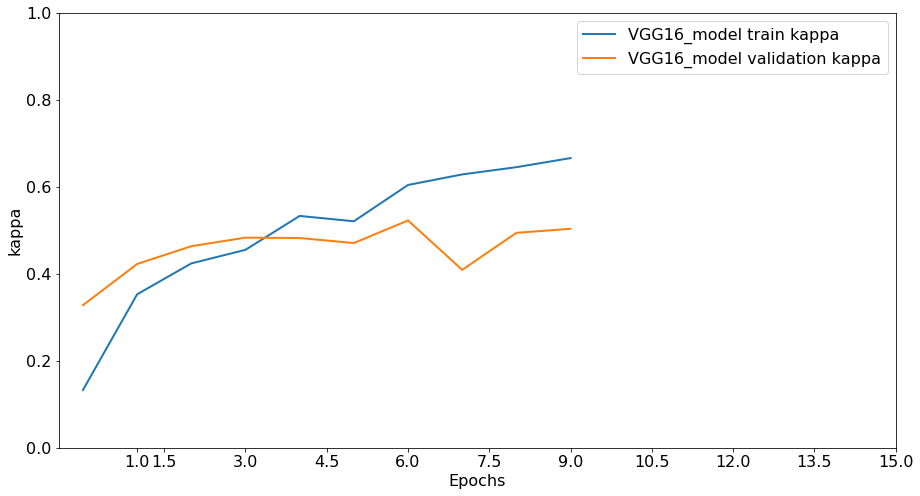

In [44]:
epochs = 15
VGG16_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = VGG16_model.fit(train_generator,validation_data = valid_generator, epochs = epochs, callbacks = my_callbacks)
print('Finished training.')
print('------------------')
VGG16_model.summary()
filename = '/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_VGG16Final_CLAHE.h5'
VGG16_model.save(filename)
print('>Saved %s' % filename)
VGG16_model_eval = VGG16_model.evaluate(test_generator)
clean_up(model=VGG16_model)
print_results(model_name='VGG16_model',epochs= epochs,hs = hs,model_eval = VGG16_model_eval)

## Applying Confusion Matrix

### Train Data

62/62 [==============================] - 855s 14s/step


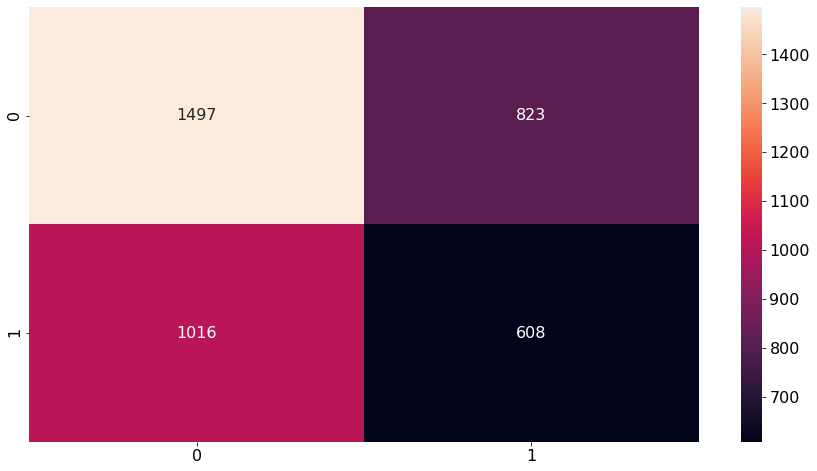

In [45]:
y_pred_train= VGG16_model.predict(train_generator) # validate Predictions
y_train = train.label_index.values
y_pred_train_binary = [1 if val >= 0.5 else 0 for val in y_pred_train.ravel()]
cm = confusion_matrix(y_train,y_pred_train_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [46]:
tn, fp, fn, tp = confusion_matrix(y_train,y_pred_train_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 608
True Negatives: 1497
False Positives: 823
False Negatives: 1016


### Valid Data

16/16 [==============================] - 212s 13s/step


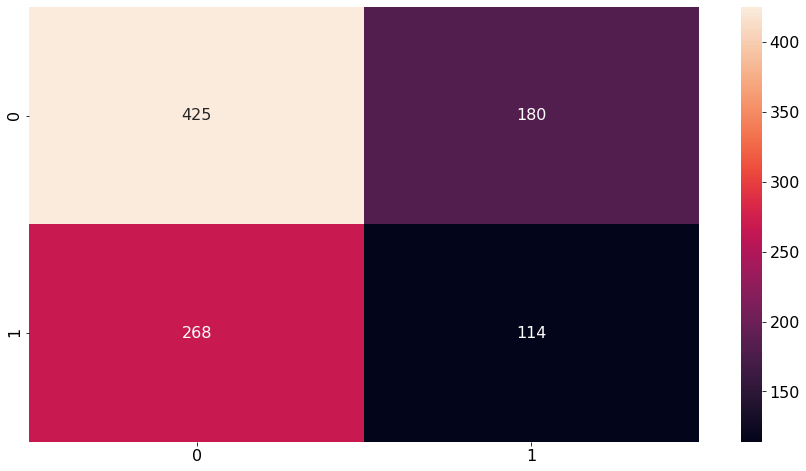

In [47]:
y_pred_valid= VGG16_model.predict(valid_generator)
y_valid = valid.label_index.values
y_pred_binary = [1 if val >= 0.5 else 0 for val in y_pred_valid.ravel()]
cm = confusion_matrix(y_valid,y_pred_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [48]:
tn, fp, fn, tp = confusion_matrix(y_valid,y_pred_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 114
True Negatives: 425
False Positives: 180
False Negatives: 268


### Test Data

8/8 [==============================] - 99s 12s/step


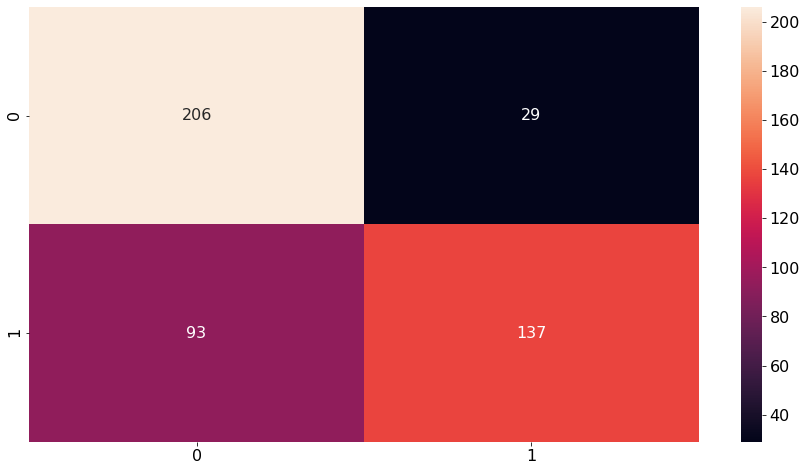

In [49]:
y_pred_test=  VGG16_model.predict(test_generator) 
y_test = test.label_index.values
y_pred_test_binary = [1 if val >= 0.5 else 0 for val in y_pred_test.ravel()]
cm = confusion_matrix(y_test,y_pred_test_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [50]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_test_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 137
True Negatives: 206
False Positives: 29
False Negatives: 93


In [51]:
# import numpy as np
# from sklearn.metrics import roc_curve, auc, f1_score, precision_score
# import matplotlib.pyplot as plt

# # Assuming you have model predictions (predicted_probs) and true labels (true_labels)
# # Make sure both 'predicted_probs' and 'true_labels' are numpy arrays

# # Calculate F1 Score
# f1 = f1_score(y_test, y_pred_test_binary > 0.5)  # Use a threshold (e.g., 0.5) to convert probabilities to binary predictions
# print(f'F1 Score: {f1}')

# # Calculate Precision
# precision = precision_score(y_test, y_pred_test_binary > 0.5)
# print(f'Precision: {precision}')

# # Calculate ROC Curve
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_binary)
# roc_auc = auc(fpr, tpr)
# # Plot ROC Curve
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc='lower right')
# plt.show()



### DenseNet121 Pre-trained Model

In [52]:
def build_model():
    base_model = keras.applications.DenseNet121(input_shape=(224, 224,3),
                             weights='imagenet',
                             include_top=False,
                             pooling='avg')
    for layer in base_model.layers:
        layer.trainable=False



    x = base_model.output
    predictions = Dense(1,activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

dense_model = build_model()

29084464/29084464 [==============================] - 11s 0us/step


In [54]:
epochs = 15
dense_model.compile(optimizer=Adam(learning_rate= 0.001), loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = dense_model.fit_generator(train_generator,validation_data = valid_generator, epochs = epochs,callbacks= my_callbacks)
print('Finished training.')
print('------------------')
dense_model.summary()
# filename = '/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_DenseNet121Final_CLAHE.h5'
# dense_model.save(filename)
# print('>Saved %s' % filename)
# dense_model_eval = dense_model.evaluate(test_generator)
# clean_up(model=dense_model)
# print_results(model_name='Dense121_model',epochs= epochs,hs = hs,model_eval = dense_model_eval)

<ipython-input-54-d011fd47c576>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hs = dense_model.fit_generator(train_generator,validation_data = valid_generator, epochs = epochs,callbacks= my_callbacks)


Epoch 1/15
62/62 [==============================] - 453s 7s/step - loss: 0.7638 - auc: 0.5277 - accuracy: 0.5538 - kappa: 0.0475 - val_loss: 0.7047 - val_auc: 0.5454 - val_accuracy: 0.5724 - val_kappa: 0.0503 - lr: 0.0010
Epoch 2/15
62/62 [==============================] - 431s 7s/step - loss: 0.6750 - auc: 0.6057 - accuracy: 0.5979 - kappa: 0.1372 - val_loss: 0.6706 - val_auc: 0.5952 - val_accuracy: 0.6018 - val_kappa: 0.1023 - lr: 0.0010
Epoch 3/15
62/62 [==============================] - 430s 7s/step - loss: 0.6513 - auc: 0.6431 - accuracy: 0.6235 - kappa: 0.1919 - val_loss: 0.6553 - val_auc: 0.6222 - val_accuracy: 0.6342 - val_kappa: 0.1598 - lr: 0.0010
Epoch 4/15
62/62 [==============================] - 440s 7s/step - loss: 0.6450 - auc: 0.6593 - accuracy: 0.6344 - kappa: 0.2199 - val_loss: 0.6467 - val_auc: 0.6451 - val_accuracy: 0.6474 - val_kappa: 0.1784 - lr: 0.0010
Epoch 5/15
62/62 [==============================] - 438s 7s/step - loss: 0.6239 - auc: 0.6888 - accuracy: 0.6549

 rmalization)                                                                                     
                                                                                                  
 conv2_block3_0_relu (Activ  (None, 56, 56, 128)          0         ['conv2_block3_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 128)          16384     ['conv2_block3_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 128)          512       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 pool2_bn (BatchNormalizati  (None, 56, 56, 256)          1024      ['conv2_block6_concat[0][0]'] 
 on)                                                                                              
                                                                                                  
 pool2_relu (Activation)     (None, 56, 56, 256)          0         ['pool2_bn[0][0]']            
                                                                                                  
 pool2_conv (Conv2D)         (None, 56, 56, 128)          32768     ['pool2_relu[0][0]']          
                                                                                                  
 pool2_pool (AveragePooling  (None, 28, 28, 128)          0         ['pool2_conv[0][0]']          
 2D)                                                                                              
                                                                                                  
 conv3_blo

 rmalization)                                                                                     
                                                                                                  
 conv3_block4_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block4_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block4_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block4_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block4_concat (Conca  (None, 28, 28, 256)          0         ['conv3_block3_concat[0][0]', 
 tenate)                                                             'conv3_block4_2_conv[0][0]'] 
          

 conv3_block8_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block8_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block8_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block8_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block8_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block8_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block8_concat (Conca  (None, 28, 28, 384)          0         ['conv3_block7_concat[0][0]', 
 tenate)  

                                                                                                  
 conv3_block12_1_bn (BatchN  (None, 28, 28, 128)          512       ['conv3_block12_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv3_block12_1_relu (Acti  (None, 28, 28, 128)          0         ['conv3_block12_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv3_block12_2_conv (Conv  (None, 28, 28, 32)           36864     ['conv3_block12_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv3_blo

 conv4_block3_concat (Conca  (None, 14, 14, 352)          0         ['conv4_block2_concat[0][0]', 
 tenate)                                                             'conv4_block3_2_conv[0][0]'] 
                                                                                                  
 conv4_block4_0_bn (BatchNo  (None, 14, 14, 352)          1408      ['conv4_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block4_0_relu (Activ  (None, 14, 14, 352)          0         ['conv4_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 128)          45056     ['conv4_block4_0_relu[0][0]'] 
 D)       

                                                                                                  
 conv4_block7_concat (Conca  (None, 14, 14, 480)          0         ['conv4_block6_concat[0][0]', 
 tenate)                                                             'conv4_block7_2_conv[0][0]'] 
                                                                                                  
 conv4_block8_0_bn (BatchNo  (None, 14, 14, 480)          1920      ['conv4_block7_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block8_0_relu (Activ  (None, 14, 14, 480)          0         ['conv4_block8_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block11_concat (Conc  (None, 14, 14, 608)          0         ['conv4_block10_concat[0][0]',
 atenate)                                                            'conv4_block11_2_conv[0][0]']
                                                                                                  
 conv4_block12_0_bn (BatchN  (None, 14, 14, 608)          2432      ['conv4_block11_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block12_0_relu (Acti  (None, 14, 14, 608)          0         ['conv4_block12_0_bn[0][0]']  
 vation)                                                                                          
          

 conv4_block15_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block15_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block15_concat (Conc  (None, 14, 14, 736)          0         ['conv4_block14_concat[0][0]',
 atenate)                                                            'conv4_block15_2_conv[0][0]']
                                                                                                  
 conv4_block16_0_bn (BatchN  (None, 14, 14, 736)          2944      ['conv4_block15_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block16_0_relu (Acti  (None, 14, 14, 736)          0         ['conv4_block16_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv4_block19_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block19_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block19_concat (Conc  (None, 14, 14, 864)          0         ['conv4_block18_concat[0][0]',
 atenate)                                                            'conv4_block19_2_conv[0][0]']
                                                                                                  
 conv4_block20_0_bn (BatchN  (None, 14, 14, 864)          3456      ['conv4_block19_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block23_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block23_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block23_concat (Conc  (None, 14, 14, 992)          0         ['conv4_block22_concat[0][0]',
 atenate)                                                            'conv4_block23_2_conv[0][0]']
                                                                                                  
 conv4_block24_0_bn (BatchN  (None, 14, 14, 992)          3968      ['conv4_block23_concat[0][0]']
 ormalization)                                                                                    
          

                                                                                                  
 conv5_block3_0_relu (Activ  (None, 7, 7, 576)            0         ['conv5_block3_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_1_conv (Conv2  (None, 7, 7, 128)            73728     ['conv5_block3_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_1_bn (BatchNo  (None, 7, 7, 128)            512       ['conv5_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_blo

 rmalization)                                                                                     
                                                                                                  
 conv5_block7_0_relu (Activ  (None, 7, 7, 704)            0         ['conv5_block7_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block7_1_conv (Conv2  (None, 7, 7, 128)            90112     ['conv5_block7_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block7_1_bn (BatchNo  (None, 7, 7, 128)            512       ['conv5_block7_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv5_block11_0_bn (BatchN  (None, 7, 7, 832)            3328      ['conv5_block10_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block11_0_relu (Acti  (None, 7, 7, 832)            0         ['conv5_block11_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block11_1_conv (Conv  (None, 7, 7, 128)            106496    ['conv5_block11_0_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block11_1_bn (BatchN  (None, 7, 7, 128)            512       ['conv5_block11_1_conv[0][0]']
 ormalizat

                                                                                                  
 conv5_block15_0_bn (BatchN  (None, 7, 7, 960)            3840      ['conv5_block14_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block15_0_relu (Acti  (None, 7, 7, 960)            0         ['conv5_block15_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block15_1_conv (Conv  (None, 7, 7, 128)            122880    ['conv5_block15_0_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_blo

NameError: name 'dmodel' is not defined

>Saved /Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_DenseNet121Final_CLAHE.h5
8/8 [==============================] - 51s 6s/step - loss: 0.6401 - auc: 0.7036 - accuracy: 0.6108 - kappa: 0.2185
...Finished clean up...
Train Loss     : 0.60003
Validation Loss: 0.63882
Test Loss      : 0.64012
---
Train AUC     : 0.72019
Validation AUC: 0.68164
Test AUC      : 0.70355
---
Train Accuracy     : 0.67825
Validation Accuracy: 0.65755
Test Accuracy      : 0.61075
---
Train Kappa     : 0.31105
Validation Kappa: 0.31105
Test Kappa      : 0.21849


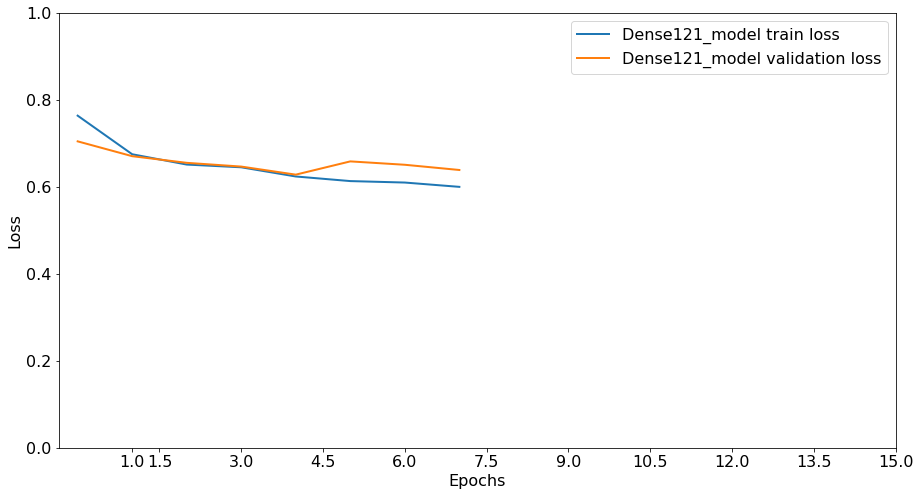

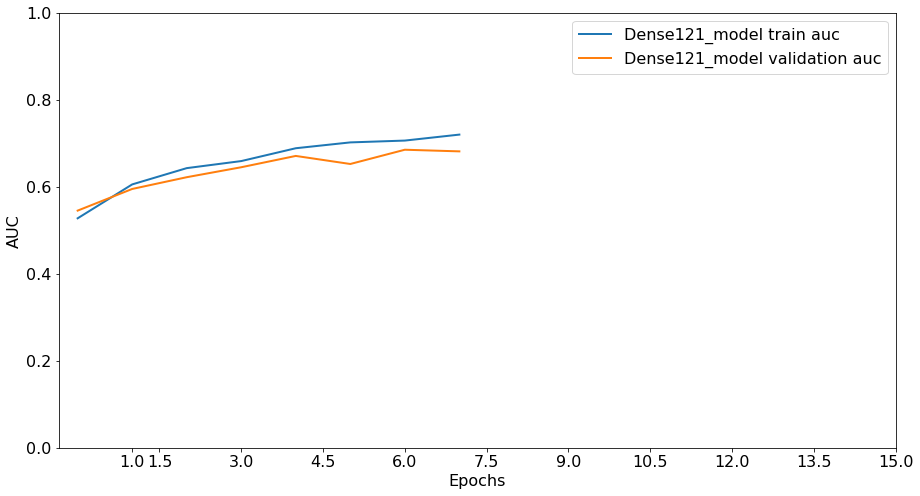

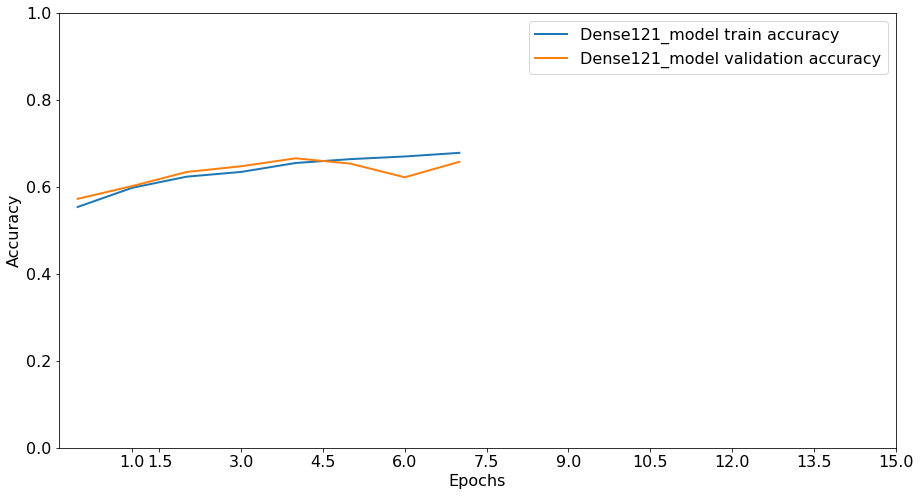

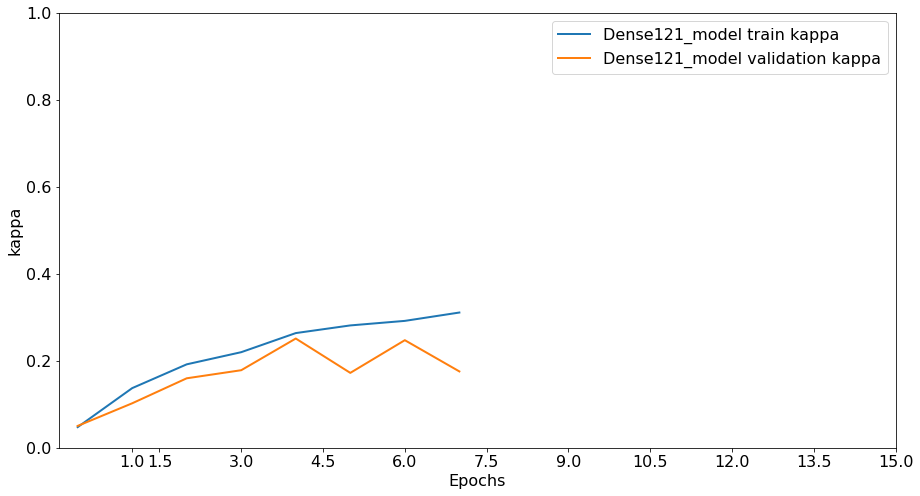

In [55]:
filename = '/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_DenseNet121Final_CLAHE.h5'
dense_model.save(filename)
print('>Saved %s' % filename)
dense_model_eval = dense_model.evaluate(test_generator)
clean_up(model=dense_model)
print_results(model_name='Dense121_model',epochs= epochs,hs = hs,model_eval = dense_model_eval)

## Applying Confusion Matrix

### Train Data

62/62 [==============================] - 368s 6s/step


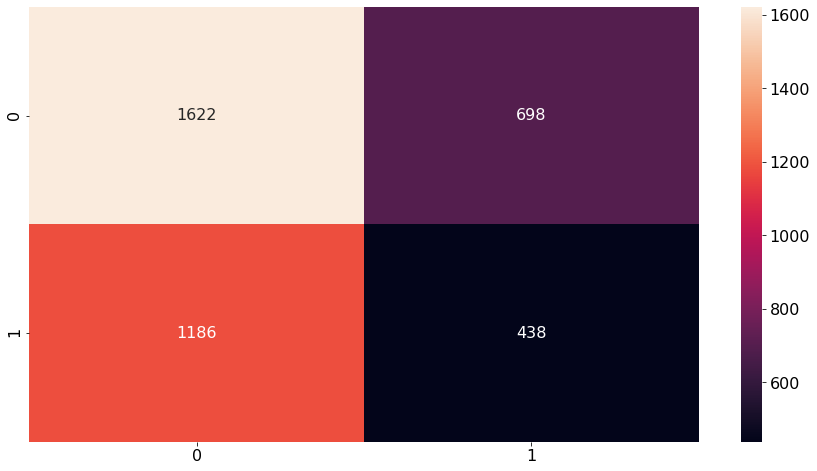

In [56]:
y_pred_train= dense_model.predict(train_generator) # validate Predictions
y_train = train.label_index.values
y_pred_train_binary = [1 if val >= 0.5 else 0 for val in y_pred_train.ravel()]
cm = confusion_matrix(y_train,y_pred_train_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [57]:
tn, fp, fn, tp = confusion_matrix(y_train,y_pred_train_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 438
True Negatives: 1622
False Positives: 698
False Negatives: 1186


### Valid Data

16/16 [==============================] - 89s 6s/step


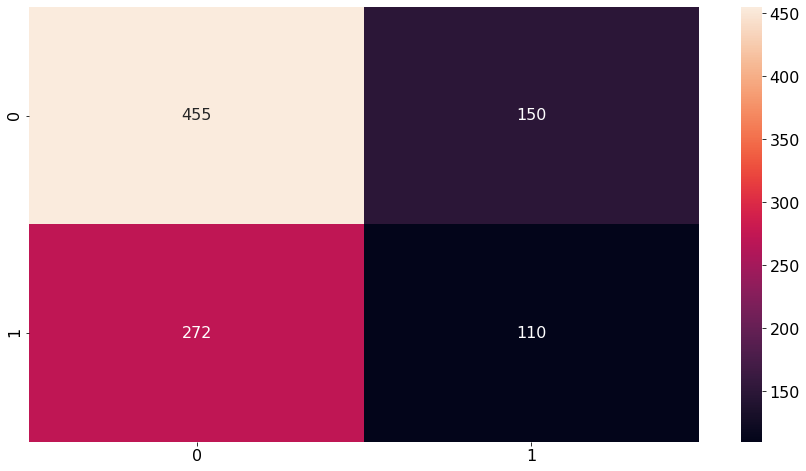

In [58]:
y_pred_valid= dense_model.predict(valid_generator)
y_valid = valid.label_index.values
y_pred_binary = [1 if val >= 0.5 else 0 for val in y_pred_valid.ravel()]
cm = confusion_matrix(y_valid,y_pred_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [59]:
tn, fp, fn, tp = confusion_matrix(y_valid,y_pred_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 110
True Negatives: 455
False Positives: 150
False Negatives: 272


### Test Data

8/8 [==============================] - 42s 5s/step


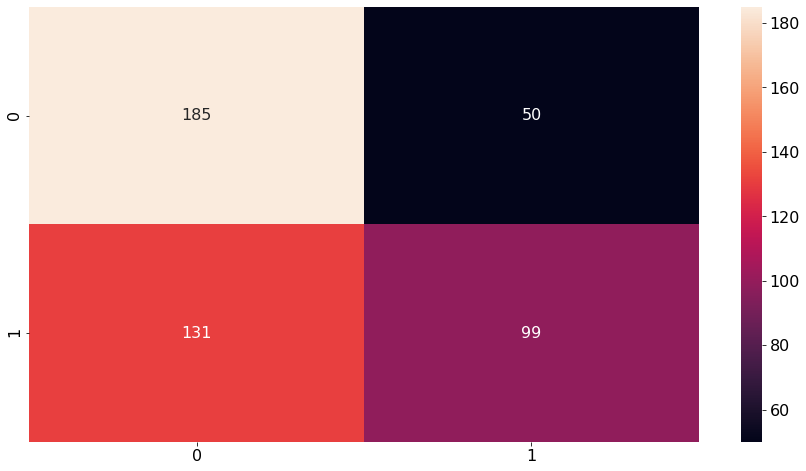

In [60]:
y_pred_test=  dense_model.predict(test_generator) 
y_test = test.label_index.values
y_pred_test_binary = [1 if val >= 0.5 else 0 for val in y_pred_test.ravel()]
cm = confusion_matrix(y_test,y_pred_test_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [61]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_test_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 99
True Negatives: 185
False Positives: 50
False Negatives: 131


# Esemble Model (ResNet50, VGG16, DenseNet121)

In [62]:
def load_all_models_eval():
    list_model  = ['model_RESNET50Final_CLAHE','model_VGG16Final_CLAHE','model_DenseNet121Final_CLAHE']
    for name in list_model:
        #os.chdir('/kaggle/input')
        filename = '/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/' + name + '.h5'
        print(filename)
        print('>loaded %s' % filename)
        model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ name
        #os.chdir('/kaggle/input/mura-v11')
        model_eval = model.evaluate(test_generator)
        clean_up(model=model)
        clean_up(model=model_eval)

In [63]:
load_all_models_eval()

/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_RESNET50Final_CLAHE.h5
>loaded /Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_RESNET50Final_CLAHE.h5
8/8 [==============================] - 41s 5s/step - loss: 0.5292 - auc: 0.8159 - accuracy: 0.7419 - kappa: 0.4821
...Finished clean up...
...Finished clean up...
/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_VGG16Final_CLAHE.h5
>loaded /Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_VGG16Final_CLAHE.h5
8/8 [==============================] - 101s 12s/step - loss: 0.6378 - auc: 0.7790 - accuracy: 0.7376 - kappa: 0.4737
...Finished clean up...
...Finished clean up...
/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_DenseNet121Final_CLAHE.h5
>loaded /Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_DenseNet121Final_CLAHE.h5
8/8 [==============================] - 42s 5s/step - loss: 0.6401 - auc: 0.7036 - accuracy: 0.6108 - kappa: 0.2185
...Finished clean up...
...Finished clean up...

In [64]:
def ens_all_models_load():
    all_models = list()
    list_model  = ['model_RESNET50Final_CLAHE','model_VGG16Final_CLAHE','model_DenseNet121Final_CLAHE']
    for name in list_model:
        #os.chdir('/kaggle/input')
        filename = '/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/' + name + '.h5'
        print(filename)
        print('>loaded %s' % filename)
        model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ name
        #os.chdir('/kaggle/input/mura-v11')
        all_models.append(model)
        clean_up(model=model)

    return all_models

def ensembleModels(models, model_input,nameip):
    yModels=[model(model_input) for model in models]
    yAvg=average(yModels)
    modelEns = Model(inputs=model_input, outputs=yAvg, name=nameip)

    return modelEns

def ens_all_models():
    members = ens_all_models_load()
    print('Loaded %d models' % len(members))
    model_input = Input(shape=input_shape)
    modelEns = ensembleModels(members, model_input,"modelEnsemble")
    return modelEns

In [65]:
from tensorflow.keras.layers import average
modelEns = ens_all_models()

/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_RESNET50Final_CLAHE.h5
>loaded /Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_RESNET50Final_CLAHE.h5
...Finished clean up...
/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_VGG16Final_CLAHE.h5
>loaded /Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_VGG16Final_CLAHE.h5
...Finished clean up...
/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_DenseNet121Final_CLAHE.h5
>loaded /Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_DenseNet121Final_CLAHE.h5
...Finished clean up...
Loaded 3 models


In [66]:
epochs = 15
modelEns.compile(optimizer=Adam(learning_rate= 0.001), loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = modelEns.fit(train_generator,validation_data = valid_generator, epochs = epochs,callbacks= my_callbacks)
print('Finished training.')
print('------------------')
modelEns.summary()
# filename = '/Users/rac/Desktop/Project/MURA_Modified/Mura_CLAHE/model_Essemble1.h5'
# modelEns.save(filename)
# print('>Saved %s' % filename)
# modelEns_eval = modelEns.evaluate(test_generator)
# clean_up(model=modelEns)
# print_results(model_name='Ensemble_model',epochs= epochs,hs = hs,model_eval = modelEns_eval)

Epoch 1/15
62/62 [==============================] - 1707s 27s/step - loss: 0.4280 - auc: 0.9059 - accuracy: 0.8299 - kappa: 0.6383 - val_loss: 0.5031 - val_auc: 0.8178 - val_accuracy: 0.7822 - val_kappa: 0.5193 - lr: 0.0010
Epoch 2/15
62/62 [==============================] - 1725s 28s/step - loss: 0.4130 - auc: 0.9095 - accuracy: 0.8347 - kappa: 0.6494 - val_loss: 0.5174 - val_auc: 0.8104 - val_accuracy: 0.7670 - val_kappa: 0.5093 - lr: 0.0010
Epoch 3/15
62/62 [==============================] - 1997s 32s/step - loss: 0.3921 - auc: 0.9258 - accuracy: 0.8562 - kappa: 0.6961 - val_loss: 0.4963 - val_auc: 0.8224 - val_accuracy: 0.7953 - val_kappa: 0.5545 - lr: 0.0010
Epoch 4/15
62/62 [==============================] - 1872s 30s/step - loss: 0.3902 - auc: 0.9236 - accuracy: 0.8527 - kappa: 0.6886 - val_loss: 0.4905 - val_auc: 0.8259 - val_accuracy: 0.8004 - val_kappa: 0.5618 - lr: 0.0010
Epoch 5/15
62/62 [==============================] - 1878s 30s/step - loss: 0.3712 - auc: 0.9374 - accura

ValueError: Unable to create dataset (name already exists)

In [75]:
for i in range(len(modelEns.weights)):
    modelEns.weights[i]._handle_name = modelEns.weights[i].name + "_" + str(i)
    

# Must do this

filename = '/Users/rac/Desktop/Project/MURA_Modified/model_Essemble1_Final_Real.h5'
modelEns.save(filename)
print('>Saved %s' % filename)
modelEns_eval = modelEns.evaluate(test_generator)
clean_up(model=modelEns)
print_results(model_name='Ensemble_model',epochs= epochs,hs = hs,model_eval = modelEns_eval)

ValueError: Unable to create dataset (name already exists)

## Applying Confusion Matrix

### Train Data

62/62 [==============================] - 7312s 119s/step


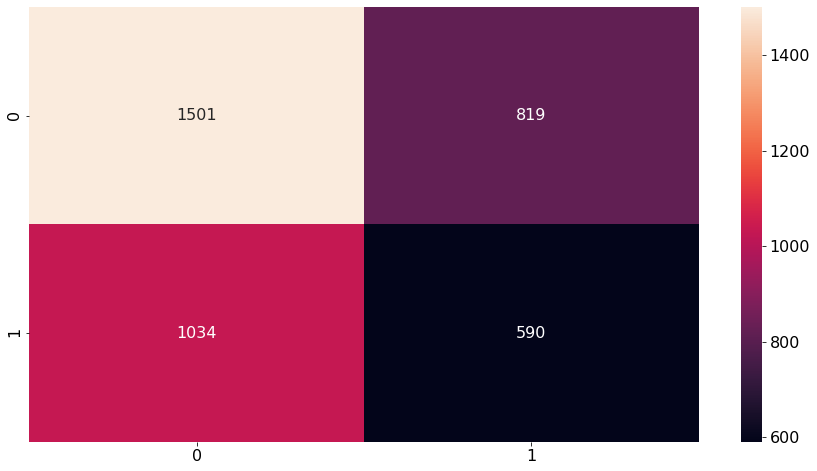

In [69]:
y_pred_train= modelEns.predict(train_generator) # validate Predictions
y_train = train.label_index.values
y_pred_train_binary = [1 if val >= 0.5 else 0 for val in y_pred_train.ravel()]
cm = confusion_matrix(y_train,y_pred_train_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [70]:
tn, fp, fn, tp = confusion_matrix(y_train,y_pred_train_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 590
True Negatives: 1501
False Positives: 819
False Negatives: 1034


### Valid Data

16/16 [==============================] - 379s 23s/step


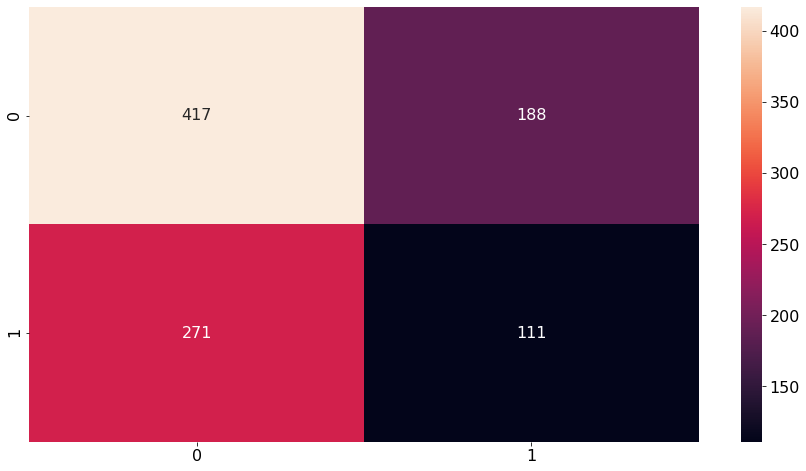

In [71]:
y_pred_valid= modelEns.predict(valid_generator)
y_valid = valid.label_index.values
y_pred_binary = [1 if val >= 0.5 else 0 for val in y_pred_valid.ravel()]
cm = confusion_matrix(y_valid,y_pred_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [72]:
tn, fp, fn, tp = confusion_matrix(y_valid,y_pred_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 111
True Negatives: 417
False Positives: 188
False Negatives: 271


### Test Data

8/8 [==============================] - 177s 22s/step


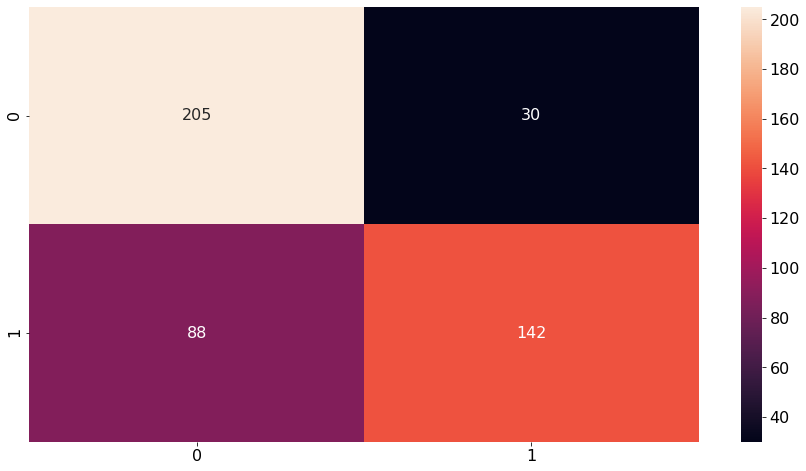

In [73]:
y_pred_test=  modelEns.predict(test_generator) 
y_test = test.label_index.values
y_pred_test_binary = [1 if val >= 0.5 else 0 for val in y_pred_test.ravel()]
cm = confusion_matrix(y_test,y_pred_test_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [74]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_test_binary).ravel()
# Print TP, TN, FP, FN
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 142
True Negatives: 205
False Positives: 30
False Negatives: 88


# End of Project

8/8 [==============================] - 188s 23s/step


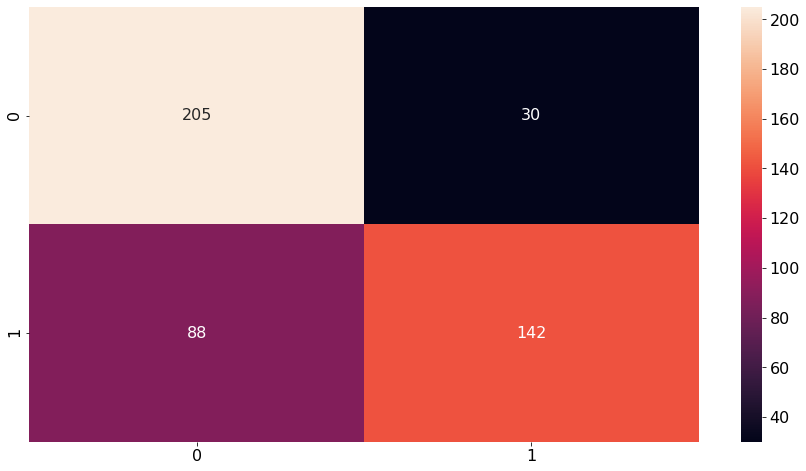

In [76]:
filename = '/Users/rac/Desktop/Project/MURA_Modified/model_Essemble1_Final_Real.h5'
modelEnsemble = load_model(filename,custom_objects={'metrics':metrics})
y_pred_test=  modelEnsemble.predict(test_generator) 
y_test = test.label_index.values
y_pred_test_binary = [1 if val >= 0.5 else 0 for val in y_pred_test.ravel()]
cm = confusion_matrix(y_test,y_pred_test_binary)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

8/8 [==============================] - 203s 24s/step - loss: 0.5291 - auc: 0.8196 - accuracy: 0.7462 - kappa: 0.4910
...Finished clean up...
Train Loss     : 0.36360
Validation Loss: 0.50256
Test Loss      : 0.52908
---
Train AUC     : 0.93644
Validation AUC: 0.81803
Test AUC      : 0.81963
---
Train Accuracy     : 0.86029
Validation Accuracy: 0.77609
Test Accuracy      : 0.74624
---
Train Kappa     : 0.70482
Validation Kappa: 0.70482
Test Kappa      : 0.49105


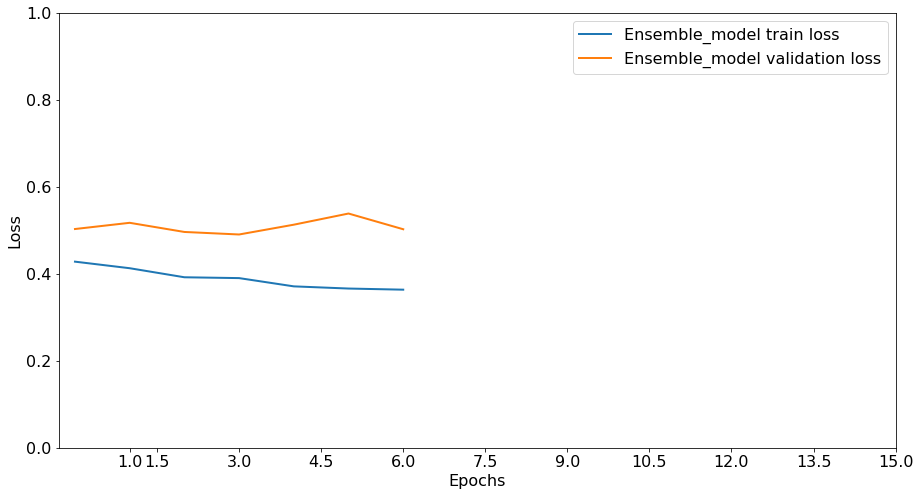

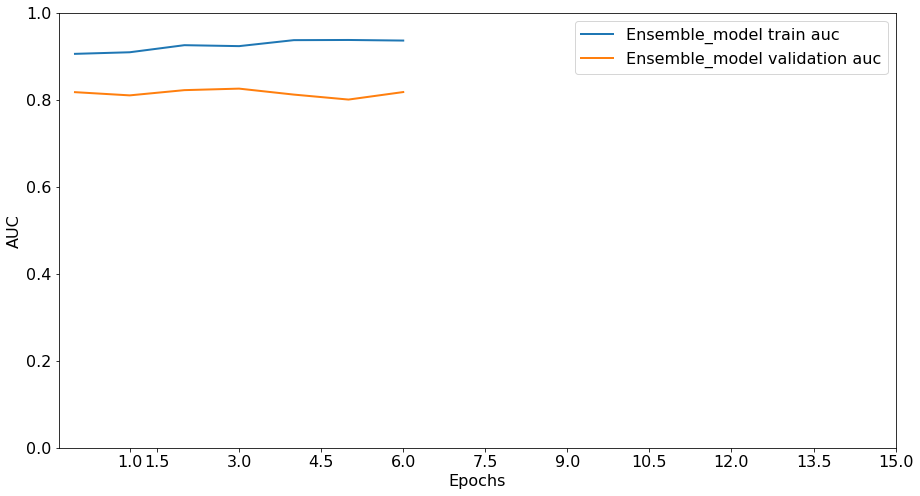

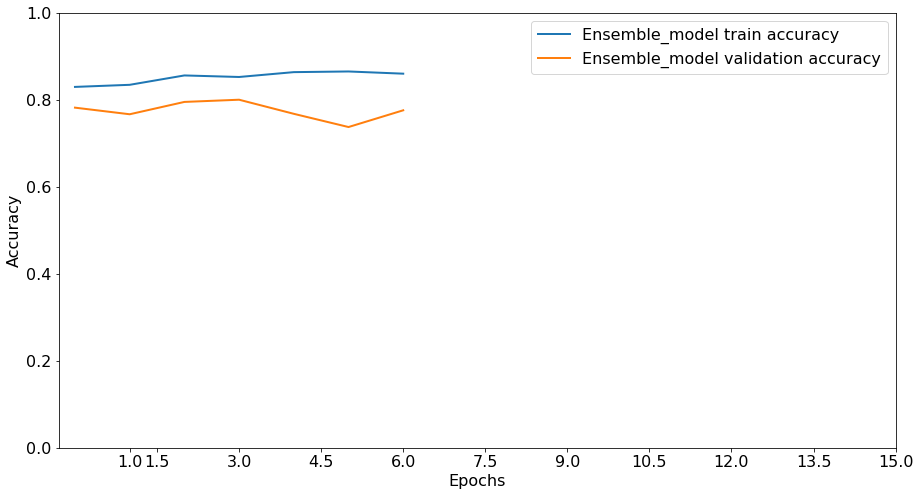

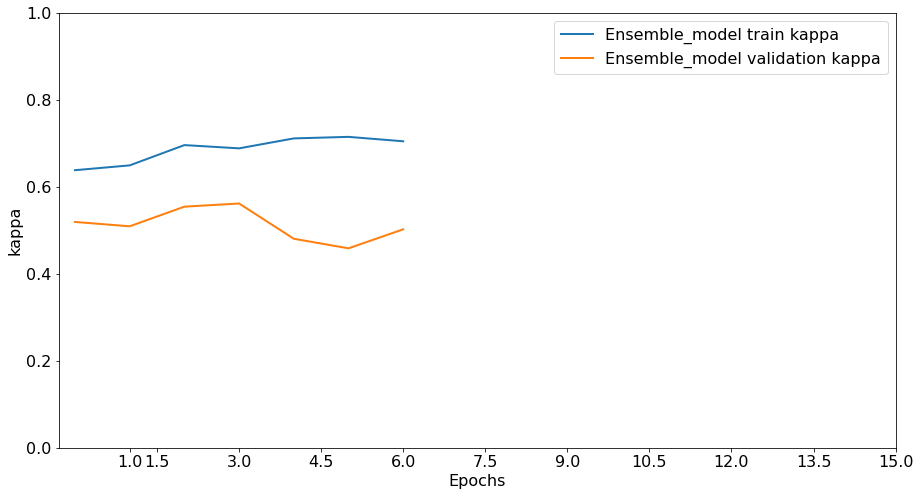

In [77]:
modelEnsemble_eva = modelEnsemble.evaluate(test_generator)
clean_up(model=modelEnsemble)
print_results(model_name='Ensemble_model',epochs= epochs,hs = hs,model_eval = modelEnsemble_eva)